In [4]:
#imports
import numpy as np
from skimage.measure import label, regionprops
import skimage.draw 
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from tqdm import tqdm_notebook
from PIL import Image
import argparse
# from Tkinter import *

In [5]:
img = imageio.imread("/home/kemerelab/Ariel/darkflow/VOCdevkit/VOC2007/JPEGImages/000001.jpg")

In [11]:
start = (48,240)
end = (195,371)
img3 = cv2.circle(img,end,10, (255,255,255))
img2 = cv2.rectangle(img, start, end, (255,255,255))

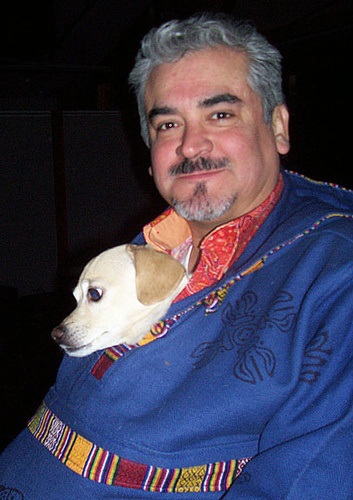

In [12]:
Image.open("/home/kemerelab/Ariel/darkflow/VOCdevkit/VOC2007/JPEGImages/000001.jpg")

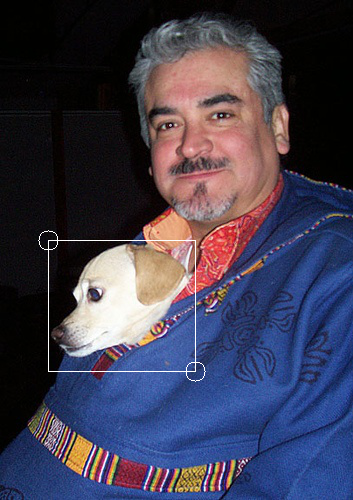

In [13]:
Image.fromarray(img2,"RGB" )

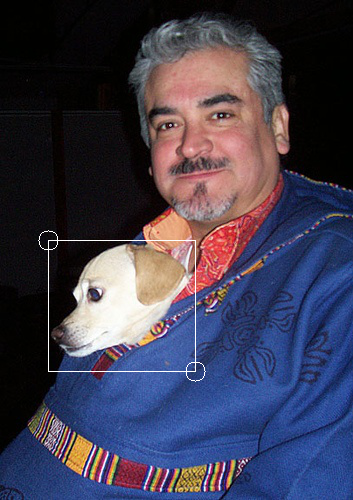

In [14]:
Image.fromarray(img3,"RGB")

In [6]:
source_pts = np.array([[100, 90], [475, 70], [425, 370], [75, 470]], dtype = 'float32') #pixels!
dst_pts = np.array([[0, 0], [100, 0], [80, 80], [0, 100]], dtype = 'float32') #cm

homography_matrix, _ = cv2.findHomography(source_pts, dst_pts, cv2.RANSAC, 5.0) #not sure what the 5.0 is really doing seems to work though
POINTMOO = np.array([[75,470]],dtype = 'float32')
POINTMOO = np.array([POINTMOO])
dst_pt = cv2.perspectiveTransform(POINTMOO, homography_matrix)

In [7]:
#Locations of objects and distance thresholds (how close does the rat have to be to be near it)
familiarObject_center_x = 380
familiarObject_center_y = 160
realWorld_famObj_center = cv2.perspectiveTransform(np.array([np.array([[familiarObject_center_x,familiarObject_center_y]], dtype='float32')]), homography_matrix)
familiarObject_center_x_realWorld = realWorld_famObj_center[0][0][0]
familiarObject_center_y_realWorld = realWorld_famObj_center[0][0][1]
DistanceThreshold_familiarObject = 22;
numFrames_FamiliarObject = 0;

novelObject_center_x = 210
novelObject_center_y = 320
realWorld_novelObj_center = cv2.perspectiveTransform(np.array([np.array([[novelObject_center_x,novelObject_center_y]],dtype='float32')]), homography_matrix)
novelObject_center_x_realWorld = realWorld_novelObj_center[0][0][0]
novelObject_center_y_realWorld = realWorld_novelObj_center[0][0][1]
DistanceThrehshold_NovelObject = 22;
numFrames_NovelObject = 0;

In [8]:
#setup for background model and foreground tracking
if 'fgbg' not in locals():
    fgbg = cv2.createBackgroundSubtractorKNN()
    
morph_size = 2
shadowValue = 127
learnBG = False
showShadow = False

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))

In [9]:
#chop off first X seconds
import subprocess
seconds = "26"
subprocess.call(['ffmpeg','-i', '/home/Kemerelab/Test-2-cropped1.mkv', '-ss', seconds, '/home/Kemerelab/Test-2-cropped1-1.mkv'])

1

In [ ]:
reader = imageio.get_reader('/home/kemerelab/Test-2-cropped1.mkv')
fps = reader.get_meta_data()['fps']
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    

input video file has a framerate of 30.0 fps


In [ ]:
reader = imageio.get_reader('Amanda/4_26_18.mp4')
fps = reader.get_meta_data()['fps']
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
    
        ratBlob = regions[largestBlobIndex]
        
        #print(ratBlob.perimeter)
        #ratContours = find_contours(fgmask,0.8)
        #print(ratContours)
        #ratContours = np.asarray(ratContours).reshape(-1,1,2).astype(np.int32)
        #print(ratContours)
        #cv2.drawContours(im, ratContours,0,(0,255,0),2)
        #cv2.putText(im, str(ratContours[0][0]), (30,30), cv2.FONT_HERSHEY_PLAIN,2,255)
        
        y0, x0 = ratBlob.centroid
        
#MOOO
        #Contour and line of best fit
        _, contours, _ = cv2.findContours(fgmask,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        #print(contours[0])
        #print(ratContours)
        rows, cols = im.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(contours[0], cv2.DIST_L2,0,0.01,0.01)
        cnt = contours[0]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        im = cv2.drawContours(im,[box],0,(0,0,255),2)
        minr, minc, maxr, maxc = ratBlob.bbox
        (c0x, c0y), (c1x, c1y), (c2x, c2y), (c3x, c3y) = cv2.boxPoints((rect))
        
# class Position:
#     def __init__(self, m, n):
#         self.coordinates = np.zeros((m, n))

#     def select_coordinates(self, event, x, y, flags, param, nearx, neary):
#         if event == cv2.EVENT_LBUTTONDOWN:
#             #Set coordinates to mouse position
#             self.coordinates[i, :] = [x, y]

# position = Position(reader.get_length(), 2)
# cv2.setMouseCallback('im', position.select_coordinates)
# positioncoords = []
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im', im)

    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break